In [9]:
import pyprot as pp
import pandas as pd
from tqdm import tqdm
from time import time
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import requests
import networkx as nx
import os.path
import statistics
import numpy as np
import time
import powerlaw
import domirank as dr
from decimal import Decimal, ROUND_CEILING
%matplotlib inline

help(powerlaw)

In [10]:
go_dir = '/Users/simontse/Documents/DS/GO/'
n_dir = '/Users/simontse/Documents/DS/Bioinformatics/Network/'

In [11]:
PIK3AP1_seq = 'MAASGVPRGCDILIVYSPDAEEWCQYLQTLFLSSRQVRSQKILTHRLGPEASFSAEDLSLFLSTRCVVVLLSAELVQHFHKPALLPLLQRAFHPPHRVVRLLCGVRDSEEFLDFFPDWAHWQELTCDDEPETYVAAVKKAISEDSGCDSVTDTEPEDEKVVSYSKQQNLPTVTSPGNLMVVQPDRIRCGAETTVYVIVRCKLDDRVATEAEFSPEDSPSVRMEAKVENEYTISVKAPNLSSGNVSLKIYSGDLVVCETVISYYTDMEEIGNLLSNAANPVEFMCQAFKIVPYNTETLDKLLTESLKNNIPASGLHLFGINQLEEEDMMTNQRDEELPTLLHFAAKYGLKNLTALLLTCPGALQAYSVANKHGHYPNTIAEKHGFRDLRQFIDEYVETVDMLKSHIKEELMHGEEADAVYESMAHLSTDLLMKCSLNPGCDEDLYESMAAFVPAATEDLYVEMLQASTSNPIPGDGFSRATKDSMIRKFLEGNSMGMTNLERDQCHLGQEEDVYHTVDDDEAFSVDLASRPPVPVPRPETTAPGAHQLPDNEPYIFKVFAEKSQERPGNFYVSSESIRKGPPVRPWRDRPQSSIYDPFAGMKTPGQRQLITLQEQVKLGIVNVDEAVLHFKEWQLNQKKRSESFRFQQENLKRLRDSITRRQREKQKSGKQTDLEITVPIRHSQHLPAKVEFGVYESGPRKSVIPPRTELRRGDWKTDSTSSTASSTSNRSSTRSLLSVSSGMEGDNEDNEVPEVTRSRSPGPPQVDGTPTMSLERPPRVPPRAASQRPPTRETFHPPPPVPPRGR'

In [12]:
g_lst = ['GO:0005488','GO:0071944','GO:0005575','GO:0003674','GO:0110165']

In [35]:
def getDistinctKmer(s, k):
    """
    Input: an amino acid sequence
    Process: break the sequence into n distinct k-mers where k is the length of the motif
    Output: a collection of distinct k-mers with their position in the original amino acid sequence
    """
    s = s.strip()
    snippets = []
    for i in range(0,len(s)-k,k):
        snippets.append((s[i:i+k], i, i+k))
    remainder = len(s)%k
    last_snippet = s[len(s)-remainder:]
    if last_snippet=='':
        pass
    else:
        snippets.append((last_snippet, len(s)-remainder, len(s)))
    return snippets
    
def nodeDegree(G, threshold):
    """
    Input: a directed graph
    Output: a list of nodes that exceeds the threshold on number of degree
    """
    start = time.time()
    node_lst = list(G.nodes)
    motif = []
    for node in node_lst:
        for key, value in G.nodes[node].items():
            if value=='ngram':
                motif.append(node)
    lst = [(node, G.degree[node]) for node in motif if G.degree[node]>threshold]
    print ('Time elapsed to retrive a node list: %.4f in secs' %(time.time()-start))
    return lst

def nodeInandOutDegree(G, threshold, in_deg=True, out_deg=True):
    """
    Input: a directed graph
    Output: a list of nodes that exceeds the threshold on number of degree
    """
    start = time.time()
    node_lst = list(G.nodes)
    motif = []
    for node in node_lst:
        for key, value in G.nodes[node].items():
            if value=='ngram':
                motif.append(node)
    if in_deg and out_deg:
        lst = [(node, G.degree[node]) for node in motif if G.degree[node]>threshold]
        print ('Time elapsed to retrive a node list: %.4f in secs' %(time.time()-start))
    elif in_deg:
        lst = [(node, G.degree[node]) for node in motif if G.in_degree[node]>threshold]
        print ('Time elapsed to retrive a node list: %.4f in secs' %(time.time()-start))
    elif out_deg:
        lst = [(node, G.degree[node]) for node in motif if G.out_degree[node]>threshold]
        print ('Time elapsed to retrive a node list: %.4f in secs' %(time.time()-start))
    else:
        pass
    return lst


def printSummary(min_node_length, in_threshold, out_threshold, in_deg, out_deg, suppress_print=False):
    ttl_threshold = in_threshold + out_threshold
    if in_deg and out_deg:
        if not suppress_print:
            print('The function is extracting kmers of length that exceeds %i' %min_node_length)
            print('and this function will extract nodes that have a total degree of connection that equals or exceeds %i;' %ttl_threshold)
            print('while the in-degree for a node that at least equals to or exceeds %i' %in_threshold)
            print('and the out-degree for a node that at least equals to or exceeds %i' %out_threshold)
            print('Only single consolidated list will be returned!')
            print()
        else:
            pass
    elif in_deg:
        if not suppress_print:
            print('The function is extracting kmers of length that exceeds %i' %min_node_length)
            print('and this function will extract nodes that have a in-degree of connection that exceeds %i' %in_threshold)
            print('This function will return the in-degree list ONLY.')
            print()
        else:
            pass
    elif out_deg:
        if not suppress_print:
            print('The function is extracting kmers of length that exceeds %i' %min_node_length)
            print('and this function will extract nodes that have a out-degree of connection that exceeds %i' %out_threshold)
            print('This function will return the out-degree list ONLY.')
            print()
        else:
            pass
    else:
        print('Invalid indication: no mention of which kind of connection is to be extracted!')
        print()
        return False
    return True
    

def nodeInandOutDegreeRefined(G, min_node_length, in_threshold, out_threshold, in_deg=True, out_deg=True, suppress_print=True):
    """
    Input: a directed graph
    Output: a list of nodes that exceeds the threshold on number of degree
    """
    start = time.time()

    if printSummary(min_node_length, in_threshold, out_threshold, in_deg, out_deg, suppress_print):
        node_lst = list(G.nodes)
        motif = []
        
        for node in node_lst:
            for key, value in G.nodes[node].items():
                if value=='ngram':
                    motif.append(node)

        #print ('Total number of valid nodes: %i' %len(motif))
        
        if in_deg and out_deg:
            ttl_threshold = in_threshold+out_threshold
            lst = [(node, G.degree[node]) for node in motif if (G.in_degree[node]>=in_threshold and G.out_degree[node]>=out_threshold and G.degree[node]>=ttl_threshold and len(node)>=min_node_length)]
            #print('Total number of nodes that exceeds the total degree of %i threshold: %i' %(ttl_threshold, len(lst)))
            #print()
            return lst
        elif in_deg:
            in_lst = [(node, G.degree[node]) for node in motif if (G.in_degree[node]>=in_threshold and len(node)>=min_node_length)]
            out_lst = []
            #print('Total number of nodes that exceeds the in-degree %i threshold: %i' %(in_threshold, len(in_lst)))
            #print()
            return in_lst
        elif out_deg:
            in_lst = []
            out_lst = [(node, G.degree[node]) for node in motif if (G.out_degree[node]>=out_threshold and len(node)>=min_node_length)]
            #print('Total number of nodes that exceeds the out-degree %i threshold: %i' %(out_threshold, len(out_lst)))
            #print()
            return out_lst
    else:
        pass
    
    #print ('Time elapsed to retrive a node list: %.4f in secs' %(time.time()-start))
    
def nodeInDegreeComplementary(G, min_node_length, in_threshold=0, ttl=0):
    node_lst = list(G.nodes)
    motif = []
    for node in node_lst:
        for key, value in G.nodes[node].items():
            if value=='ngram':
                motif.append(node)
    if ttl==0:
        print('Total number of degress for a node cannot be zero!')
        return []
    else:
        lst = [(node, G.degree[node]) for node in motif if (G.in_degree[node]>=in_threshold and G.degree[node]<=ttl and len(node)>=min_node_length)]
        return lst

def nodeOutDegreeComplementary(G, min_node_length, out_threshold=0, ttl=0):
    node_lst = list(G.nodes)
    motif = []
    for node in node_lst:
        for key, value in G.nodes[node].items():
            if value=='ngram':
                motif.append(node)
    if ttl==0:
        print('Total number of degress for a node cannot be zero!')
        return []
    else:
        lst = [(node, G.degree[node]) for node in motif if (G.out_degree[node]>=out_threshold and G.degree[node]<=ttl and len(node)>=min_node_length)]
        return lst

def createNGramNetwork(df, kmer):
    """
    Input: a dataframes containing a set of proteins with their corresponding Primary Accession Number and GO number
    Output: a DiGraph connecting ngrams from different proteins to form a unified network.
    """
    U = nx.DiGraph()
    df_len = len(df)
    
    for i in tqdm(range(df_len)):
        entries = df.iloc[i]    
        PrimaryAccessionNumber = entries.iloc[0]
        protein = entries.iloc[3]
        ngrams = getDistinctKmer(protein, kmer)
        G = nx.DiGraph()
        
        # Segment to turn an origin and a list of ngrams extracted from Pandas DataFrame into a list
        nodes = []
        nodes.append([PrimaryAccessionNumber, 'origin'])
        for ngram in ngrams:
            nodes.append([ngram[0], 'ngram'])
        
        # Segment to create nodes and edges
        for i in range(len(nodes)-1):
            cur = nodes[i][0]
            nxt = nodes[i+1][0]
            G.add_node(cur, nature = nodes[i][1])
            G.add_node(nxt, nature = nodes[i+1][1])
            G.add_edge(cur, nxt, weight=1)
        G.add_edge(nxt, PrimaryAccessionNumber, weight=1)
        
        # Segment to add GO to the uniprotid # Not used in this version
        #for go in GO_lst:
        #    G.add_node(go, nature='GONumber')
        #    G.add_edge(PrimaryAccessionNumber, go, weight=1)
        #    G.add_edge(go, PrimaryAccessionNumber, weight=1)

        # Merge the G with U
        U = nx.compose(U,G)
    
    return U

def createNGramNetwork_alt(df, kmer):
    """
    Input: a dataframes containing a set of proteins with their corresponding Primary Accession Number and GO number
    Output: a DiGraph connecting ngrams from different proteins to form a unified network.
    """
    U = nx.DiGraph()
    df_len = len(df)
    
    for i in tqdm(range(df_len)):
        entries = df.iloc[i]    
        PrimaryAccessionNumber = entries.iloc[0]
        protein = entries.iloc[3]
        ngrams = getDistinctKmer(protein, kmer)
        G = nx.DiGraph()
        
        # Segment to turn an origin and a list of ngrams extracted from Pandas DataFrame into a list
        nodes = []
        nodes.append([PrimaryAccessionNumber, 'origin'])
        for ngram in ngrams:
            nodes.append([ngram[0], 'ngram'])
        
        # Segment to create nodes and edges
        for i in range(len(nodes)-1):
            cur = nodes[i][0]
            nxt = nodes[i+1][0]
            G.add_node(cur, nature = nodes[i][1])
            G.add_node(nxt, nature = nodes[i+1][1])
            G.add_edge(cur, nxt, weight=1)
        G.add_edge(PrimaryAccessionNumber, nxt, weight=1) # Change the direction of the edge to make each protein network non-cicular
        
        # Segment to add GO to the uniprotid # Not used in this version
        #for go in GO_lst:
        #    G.add_node(go, nature='GONumber')
        #    G.add_edge(PrimaryAccessionNumber, go, weight=1)
        #    G.add_edge(go, PrimaryAccessionNumber, weight=1)

        # Merge the G with U
        U = nx.compose(U,G)
    
    return U

def getGoMotifInfo(G, degree):
    start = time.time()
    morethanDeg = nodeDegree(G, threshold=degree)
    motif_nodes = nodeDegree(G, threshold=0)
        
    counts = []
    for entry in morethanDeg:
        counts.append(entry[1])
    
    print ('Number of motifs with degree higher than %i: %s' %(degree, f"{len(morethanDeg):,}"))
    print ('Number of motifs in Graph: %s' %f"{len(motif_nodes):,}")
    print ('Percentage of motif with degree higher than threshold: ', f"{len(morethanDeg)/len(motif_nodes):.2%}")
    
    print ('Max Deg: %i' %max(counts))
    print ('Min Deg: %i' %min(counts))
    print ('Average Deg: %.2f' %(sum(counts)/len(counts)))
    print ('Median Deg: %.2f' %statistics.median(counts))
    print ('Mode Deg: %.2f' %statistics.mode(counts))
    
    bin_size = max(counts) - min(counts) + 1
    plt.figure(figsize=(12,6))
    plt.hist(counts, bins=bin_size)
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.title('Frequency of Degree of Kmer')
    plt.show()
    
    print ('Time elapsed to retrieve summary statistics of Graph: %.4f secs' %(time.time()-start))
    return morethanDeg

def getGOmotifgraph(df, GO, threshold):
    g = createMotifGraph(df, GO)
    motif = getGoMotifInfo(g, degree=threshold)
    return g, motif

def plotNetworkDegHistogram(lst):
    counts = []
    for entry in lst:
        counts.append(entry[1])   
    bin_size = max(counts) - min(counts) + 1
    plt.figure(figsize=(12,6))
    plt.hist(counts, bins=bin_size)
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.title('Frequency of Degree of Kmer')
    plt.show()

def plotNetwork(G):
    plt.figure(figsize=(12,6))
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=20)
    nx.draw_networkx_labels(G, pos, font_size=5)
    nx.draw_networkx_edges(G, pos, edge_color='r', arrows=True)
    plt.show()

def splitNgram(str):
    ngram = str.replace('(','').replace(')','').replace("'","").replace(',','').split(' ')
    return ngram

def extractEdgesbyNode(G, node):
    """
    Input: a DiGraph and a node that you want to find out its neighbours.
    Output: a set of edges that connects the node of interest to its incoming and outgoing nodes.
    """
    start = time.time()
    edges = dict()
    for edge in G.in_edges(node):
        edges[edge] = 'in'
    for edge in G.out_edges(node):
        edges[edge] = 'out'
    print ('Time taken to extract edges: %.4f sec' %(time.time()-start))
    return edges

def prepareDegCountData(lst, return_dict=True):
    """
    Input: a list generated from function "nodeDegree"
    Output: a python dictionary of degree as key with its number of occurences as value OR a simple list of degree
    """
    if return_dict:
        data = {}
        for entry in lst:
            if entry[1] not in data.keys():
                data[entry[1]] =1
            else:
                data[entry[1]]+=1
    else:
        data = []
        for entry in lst:
            data.append(entry[1])
    return data

def fitPowerLaw(lst):
    """
    Input: a list of kmers with their respective degree (i.e. in- & out-degree)
    Output: Test if the network follows a Power Law vs Exponential distribution and return the alpha and sigma
    of the fomula: alpha * x ^ -sigma, where sigma is a scaling factor and sigma is the exponent
    Remark:
    powerlaw is a toolbox using the statistical methods developed in Clauset et al. 2007 and Klaus et al. 2011 
    to determine if a probability distribution fits a power law.
    Jeff Alstott, Ed Bullmore, Dietmar Plenz, (2014), 
    powerlaw: a Python package for analysis of heavy-tailed distributions,
    PLoS ONE 9(1): e85777
    """
    data = prepareDegCountData(lst, return_dict=False)
    fit = powerlaw.Fit(data, xmin=1., xmax=11., discrete=True, estimate_discrete=True)
    l, p = fit.distribution_compare('power_law', 'exponential')
    alpha = fit.power_law.alpha
    sigma = fit.power_law.sigma
    #print('Fitted alpha: %.4f' %alpha)
    #if message:
    #    print('alpha: %.4f' %fit.power_law.alpha)
    #    print('sigma: %.4f' %fit.power_law.sigma)
    #    print("likelihood Ratio (Power Law Vs. Exponential Distribution): %.4f; p-value: %.4f" %(l, p))
    #    print()
    #else:
    #    pass
    return alpha, sigma, l, p

def roundup(x):
    number = Decimal(x)
    rounded_up = number.quantize(Decimal('0.0000'), rounding=ROUND_CEILING)
    return rounded_up

def runPowerLawOverMesh(X,Y):
    lst = nodeInDegreeComplementary(H, min_node_length=0, in_threshold=1, ttl=10)
    alpha, sigma, l, p = fitPowerLaw(lst)
    return (X, Y, float(alpha), float(l), float(p))

### Network Construction

In [8]:
df = pd.read_csv('PIK3AP1_homo.csv')
GO0005575_df = df[df['GO']=='GO:0005575']
print (GO0005575_df.shape[0])
PIK3AP1_seq in list(set(GO0005575_df['seq']))

14903


True

In [14]:
%%time
H = nx.read_gml(n_dir+'GO0005575_df.gml')

CPU times: user 11 s, sys: 105 ms, total: 11.1 s
Wall time: 11.1 s


In [7]:
len(H.nodes)

225550

In [10]:
GO0005575_df.loc[0]

EntryID                                                  Q8IWU5
GO                                                   GO:0005575
taxonomyID                                                 9606
seq           MGPPSLVLCLLSATVFSLLGGSSAFLSHHRLKGRFQRDRRNIRPNI...
Name: 0, dtype: object

In [16]:
G = nx.DiGraph()
seq = GO0005575_df.at[0, 'seq']
uniprotid = GO0005575_df.at[0, 'EntryID']
print(uniprotid)
print(seq)
G.add_node(uniprotid, nature='orignin')
ngrams = getDistinctKmer(s=seq, k=36)
cur = uniprotid
for node in ngrams:
    nxt = node[0]
    G.add_node(nxt, nature='ngram')
    G.add_edge(cur, nxt, weight=1)
    cur = nxt
G.add_edge(cur, uniprotid, weight=1)

Q8IWU5
MGPPSLVLCLLSATVFSLLGGSSAFLSHHRLKGRFQRDRRNIRPNIILVLTDDQDVELGSMQVMNKTRRIMEQGGAHFINAFVTTPMCCPSRSSILTGKYVHNHNTYTNNENCSSPSWQAQHESRTFAVYLNSTGYRTAFFGKYLNEYNGSYVPPGWKEWVGLLKNSRFYNYTLCRNGVKEKHGSDYSKDYLTDLITNDSVSFFRTSKKMYPHRPVLMVISHAAPHGPEDSAPQYSRLFPNASQHITPSYNYAPNPDKHWIMRYTGPMKPIHMEFTNMLQRKRLQTLMSVDDSMETIYNMLVETGELDNTYIVYTADHGYHIGQFGLVKGKSMPYEFDIRVPFYVRGPNVEAGCLNPHIVLNIDLAPTILDIAGLDIPADMDGKSILKLLDTERPVNRFHLKKKMRVWRDSFLVERGKLLHKRDNDKVDAQEENFLPKYQRVKDLCQRAEYQTACEQLGQKWQCVEDATGKLKLHKCKGPMRLGGSRALSNLVPKYYGQGSEACTCDSGDYKLSLAGRRKKLFKKKYKASYVRSRSIRSVAIEVDGRVYHVGLGDAAQPRNLTKRHWPGAPEDQDDKDGGDFSGTGGLPDYSAANPIKVTHRCYILENDTVQCDLDLYKSLQAWKDHKLHIDHEIETLQNKIKNLREVRGHLKKKRPEECDCHKISYHTQHKGRLKHRGSSLHPFRKGLQEKDKVWLLREQKRKKKLRKLLKRLQNNDTCSMPGLTCFTHDNQHWQTAPFWTLGPFCACTSANNNTYWCMRTINETHNFLFCEFATGFLEYFDLNTDPYQLMNAVNTLDRDVLNQLHVQLMELRSCKGYKQCNPRTRNMDLGLKDGGSYEQYRQFQRRKWPEMKRPSSKSLGQLWEGWEG


In [23]:
pp.parseUniprotEntry(uniprotid)

['FUNCTION: Exhibits arylsulfatase activity and highly specific glucosamine within specific subregions of intact heparin',
 'CATALYTIC ACTIVITY: Reaction=an aryl sulfate + H2O = a phenol + H(+) + sulfate;   Xref=Rhea:RHEA:17261, ChEBI:CHEBI:15377, ChEBI:CHEBI:15378,   ChEBI:CHEBI:16189, ChEBI:CHEBI:33853, ChEBI:CHEBI:140317; EC=3.1.6.1;',
 'CATALYTIC ACTIVITY: Reaction=Hydrolysis of the 6-sulfate groups of the N-acetyl-D-   glucosamine 6-sulfate units of heparan sulfate and keratan sulfate.;',
 'COFACTOR: Name=Ca(2+); Xref=ChEBI:CHEBI:29108;',
 'BIOPHYSICOCHEMICAL PROPERTIES: pH dependence:   Optimum pH is 7.0-8.0. for arylsulfatase activity.',
 'SUBCELLULAR LOCATION: Endoplasmic reticulum',
 'SUBCELLULAR LOCATION: [Extracellular sulfatase Sulf-2 secreted form]:',
 'ALTERNATIVE PRODUCTS: Event=Alternative splicing; Named isoforms=2; Name=1;   IsoId=Q8IWU5-1; Sequence=Displayed; Name=2;   IsoId=Q8IWU5-2; Sequence=VSP_013362;',
 'TISSUE SPECIFICITY: Expressed at highest levels in the ova

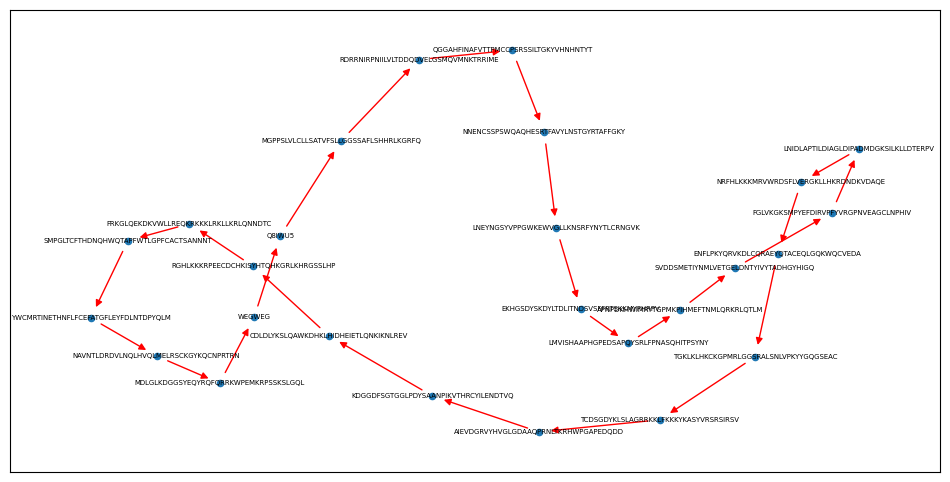

In [20]:
plotNetwork(G)

In [63]:
H.nodes(data=True)['Q8IWU5']['nature']

'origin'

In [59]:
node_lst = list(set(H.nodes()))

In [62]:
node_lst[0:10]

['TQEDTPRASSTQWNTPRASSPSRSTQLDNPRTSSTQ',
 'NDGNGKRLFYRMPGGKEVTSTEEIKGVHWASWTCVS',
 'PLISTLQSEGYMSERDGSQKVSQPSAEVWNENKERR',
 'HVLEALNDYKTMFMSGKEIKKKKHLFGLRIRVPPVP',
 'MAQQPFMAAVTQLQNSHMYAHKQEPPQYSHTSRFPS',
 'YHNLRLSIHDVPSSLWKSKLLVSYQEIPFYHIWNGT',
 'APLHLPPIPPPLPLLPPCGYPGLKAEPASPAQDAQE',
 'GLLDSKRNLNLVSSTASIKDLADVDLRIVMCLMCGD',
 'SRTHSSVIATSKLSVKPSIFHKDAATLEPSSSAKIT',
 'CSPSGILSTVSPQDVTEEGREPRPEAGEEDGSLELS']

In [8]:
lst = nodeDegree(H, 0)

Time elapsed to retrive a node list: 0.1788 in secs


In [10]:
node_lst = list(H.nodes)

motif = []
for node in node_lst:
    for key, value in H.nodes[node].items():
        if value=='ngram':
            motif.append(node)

In [11]:
len(motif), motif[0:10]

(210647,
 ['MGPPSLVLCLLSATVFSLLGGSSAFLSHHRLKGRFQ',
  'RDRRNIRPNIILVLTDDQDVELGSMQVMNKTRRIME',
  'QGGAHFINAFVTTPMCCPSRSSILTGKYVHNHNTYT',
  'NNENCSSPSWQAQHESRTFAVYLNSTGYRTAFFGKY',
  'LNEYNGSYVPPGWKEWVGLLKNSRFYNYTLCRNGVK',
  'EKHGSDYSKDYLTDLITNDSVSFFRTSKKMYPHRPV',
  'LMVISHAAPHGPEDSAPQYSRLFPNASQHITPSYNY',
  'APNPDKHWIMRYTGPMKPIHMEFTNMLQRKRLQTLM',
  'SVDDSMETIYNMLVETGELDNTYIVYTADHGYHIGQ',
  'FGLVKGKSMPYEFDIRVPFYVRGPNVEAGCLNPHIV'])

Time elapsed to retrive a node list: 0.1787 in secs
Time elapsed to retrive a node list: 0.1424 in secs
Number of motifs with degree higher than 0: 210,647
Number of motifs in Graph: 210,647
Percentage of motif with degree higher than threshold:  100.00%
Max Deg: 100
Min Deg: 2
Average Deg: 2.04
Median Deg: 2.00
Mode Deg: 2.00


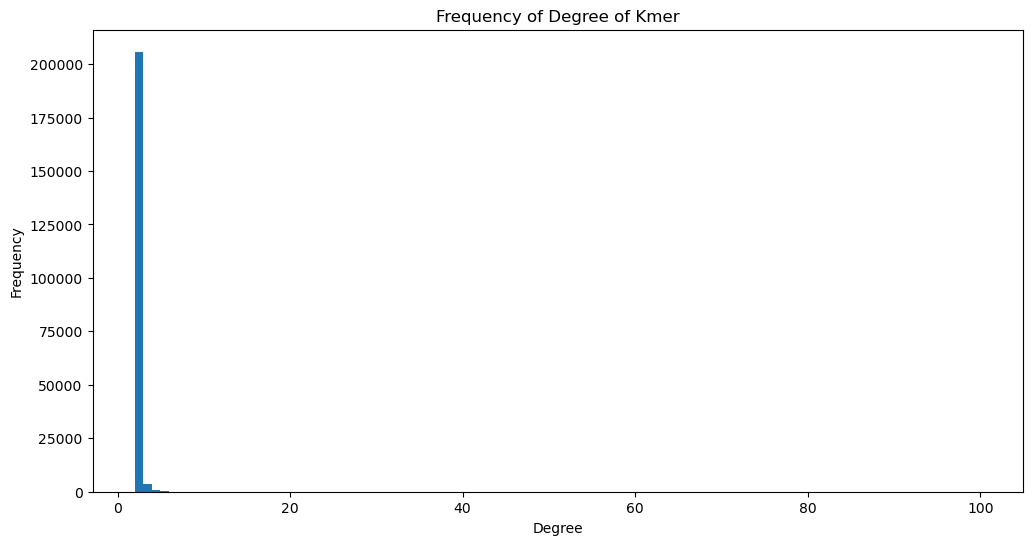

Time elapsed to retrieve summary statistics of Graph: 0.6579 secs


In [26]:
lst = getGoMotifInfo(H, 0)

In [27]:
len(lst)

210647

In [30]:
min = 999
max = 0
for entry in lst:
    if entry[1]<min:
        min=entry[1]
    if entry[1]>max:
        max=entry[1]
min, max

(2, 100)

In [28]:
alpha, sigma = fitPowerLaw(lst)

Calculating best minimal value for power law fit
alpha: 84.0738 96%
sigma: 0.1810
likelihood Ratio (Power Law Vs. Exponential Distribution): 86580.2435; p-value: 0.0000


#### A Grid search

In [16]:
from decimal import Decimal, ROUND_CEILING
def roundup(x):
    number = Decimal(x)
    rounded_up = number.quantize(Decimal('0.0000'), rounding=ROUND_CEILING)
    return rounded_up

In [17]:
def runPowerLawOverMesh(X,Y):
    lst = nodeInandOutDegreeRefined(H, min_node_length=0, in_threshold=X, out_threshold=Y, in_deg=True, out_deg=True, suppress_print=True)
    alpha, sigma, l, p = fitPowerLaw(lst)
    return (X, Y, float(alpha), float(l), float(p))

In [13]:
print(Z[0])

[[10.         11.05263158 12.10526316 13.15789474 14.21052632 15.26315789
  16.31578947 17.36842105 18.42105263 19.47368421 20.52631579 21.57894737
  22.63157895 23.68421053 24.73684211 25.78947368 26.84210526 27.89473684
  28.94736842 30.        ]
 [10.         11.05263158 12.10526316 13.15789474 14.21052632 15.26315789
  16.31578947 17.36842105 18.42105263 19.47368421 20.52631579 21.57894737
  22.63157895 23.68421053 24.73684211 25.78947368 26.84210526 27.89473684
  28.94736842 30.        ]
 [10.         11.05263158 12.10526316 13.15789474 14.21052632 15.26315789
  16.31578947 17.36842105 18.42105263 19.47368421 20.52631579 21.57894737
  22.63157895 23.68421053 24.73684211 25.78947368 26.84210526 27.89473684
  28.94736842 30.        ]
 [10.         11.05263158 12.10526316 13.15789474 14.21052632 15.26315789
  16.31578947 17.36842105 18.42105263 19.47368421 20.52631579 21.57894737
  22.63157895 23.68421053 24.73684211 25.78947368 26.84210526 27.89473684
  28.94736842 30.        ]
 [10

In [83]:
print(Z[1])

[[0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [2. 2. 2. 2.]
 [3. 3. 3. 3.]]


In [84]:
print(Z[2]), np.min(Z[2]) # alpha

[[91.78315656 91.78315656  7.07575946  8.2536782 ]
 [91.78315656 91.78315656  7.07575946  8.2536782 ]
 [ 7.56106814  7.56106814  6.7008688   6.18515751]
 [ 7.78937873  7.78937873  9.11000905  9.8918294 ]]


(None, 6.185157505069707)

In [85]:
print(Z[3]) # likelihood ration

[[6.48741999e+04 6.48741999e+04 3.09295961e+00 5.50966305e+00]
 [6.48741999e+04 6.48741999e+04 3.09295961e+00 5.50966305e+00]
 [1.79073199e+01 1.79073199e+01 1.20661808e+01 8.13080049e+00]
 [4.08357343e+01 4.08357343e+01 7.02173366e-01 8.51322475e-01]]


In [158]:
print(Z[4]), np.min(Z[4]) # p-value

[[0.00000000e+00 0.00000000e+00 2.84795274e-03 3.48673527e-02]
 [0.00000000e+00 0.00000000e+00 2.84795274e-03 3.48673527e-02]
 [1.62213154e-09 1.62213154e-09 4.64142715e-06 6.31512977e-04]
 [2.88934001e-16 2.88934001e-16 2.27794771e-01 1.20075624e-01]]


(None, 0.0)

In [121]:
Z[3]*Z[4]

array([[0.00000000e+00, 0.00000000e+00, 8.80860282e-03, 1.92107365e-01],
       [0.00000000e+00, 0.00000000e+00, 8.80860282e-03, 1.92107365e-01],
       [2.90480283e-08, 2.90480283e-08, 5.60042990e-05, 5.13470602e-03],
       [1.17988321e-14, 1.17988321e-14, 1.59951421e-01, 1.02223078e-01]])

In [107]:
I = np.ones(Z[4].shape)
I - Z[4]

array([[1.        , 1.        , 0.99715205, 0.96513265],
       [1.        , 1.        , 0.99715205, 0.96513265],
       [1.        , 1.        , 0.99999536, 0.99936849],
       [1.        , 1.        , 0.77220523, 0.87992438]])

In [108]:
K1 = np.divide(Z[3], Z[2]) # Scale down the likelihood by the alpha
K2 = K1 * Z[4] # smaller the better

In [109]:
K1

array([[7.06820318e+02, 7.06820318e+02, 4.37120514e-01, 6.67540328e-01],
       [7.06820318e+02, 7.06820318e+02, 4.37120514e-01, 6.67540328e-01],
       [2.36835848e+00, 2.36835848e+00, 1.80068900e+00, 1.31456644e+00],
       [5.24248926e+00, 5.24248926e+00, 7.70771316e-02, 8.60631983e-02]])

In [110]:
K2

array([[7.06820318e+02, 7.06820318e+02, 4.35875616e-01, 6.44264964e-01],
       [7.06820318e+02, 7.06820318e+02, 4.35875616e-01, 6.44264964e-01],
       [2.36835848e+00, 2.36835848e+00, 1.80068065e+00, 1.31373628e+00],
       [5.24248926e+00, 5.24248926e+00, 5.95193640e-02, 7.57291060e-02]])

In [111]:
np.max(K2)

706.820317959988

In [95]:
rows = len(K2)
for r in range(rows):
    cols = len(K2[r])
    for c in range(cols):
        if K2[r,c]==np.max(K2):
            print (r,c)

0 3
1 3


In [26]:
def plot(x, y, z, txt):
    fig1, ax2 = plt.subplots(layout='constrained')
    plt.figure(figsize=(8,8))
    X, Y = np.meshgrid(x, y)
    # Plot the surface
    z_grid = np.array(z).reshape(X.shape)
    CS = ax2.contourf(X, Y, z_grid, 10, cmap=plt.cm.Spectral)
    CS2 = ax2.contour(CS,  colors='r')
    ax2.set_title('Power Law')
    ax2.set_xlabel('in-deg')
    ax2.set_ylabel('out-deg')
    # Make a colorbar for the ContourSet returned by the contourf call.
    cbar = fig1.colorbar(CS)
    cbar.ax.set_ylabel('Value of the %s' %txt)
    # Add the contour line levels to the colorbar
    cbar.add_lines(CS2)
    plt.show()

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

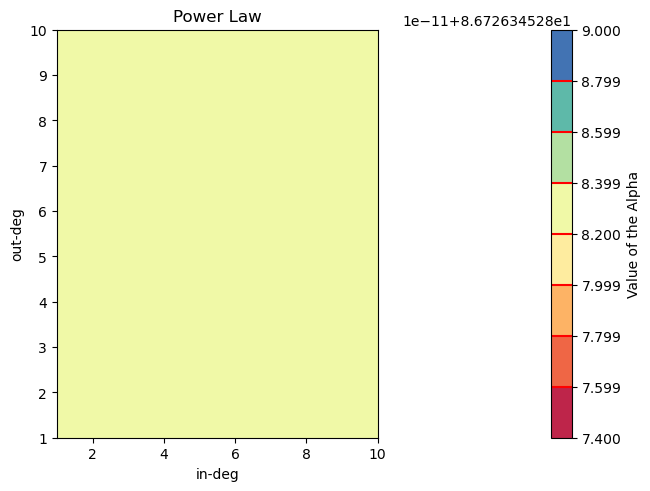

<Figure size 800x800 with 0 Axes>

In [32]:
x = np.linspace(1, 10, 10)  # In-degree
y = np.linspace(1, 10, 10)  # Out-degree
#print (x)
#print (y)
# Create a mesh grid
X, Y = np.meshgrid(x, y)
Z = np.vectorize(runPowerLawOverMesh)(X,Y)
plot(x=x,y=y,z=Z[2],txt='Alpha')

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for

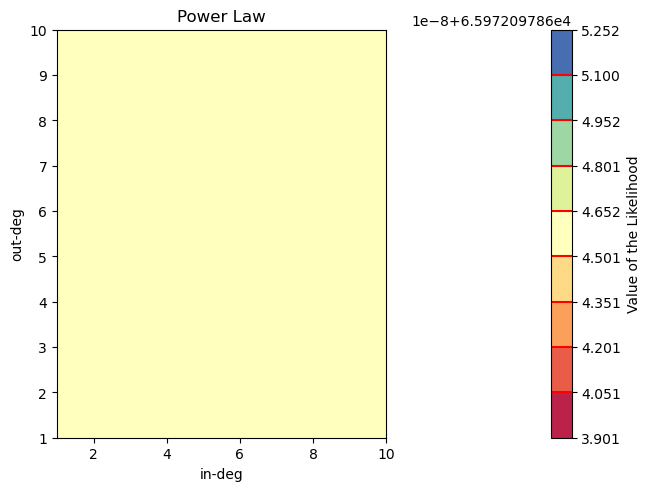

<Figure size 800x800 with 0 Axes>

In [33]:
x = np.linspace(1, 10, 10)  # In-degree
y = np.linspace(1, 10, 10)  # Out-degree
print (x)
print (y)
# Create a mesh grid
X, Y = np.meshgrid(x, y)
Z = np.vectorize(runPowerLawOverMesh)(X,Y)
plot(x=x,y=y,z=Z[3],txt='Likelihood')

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


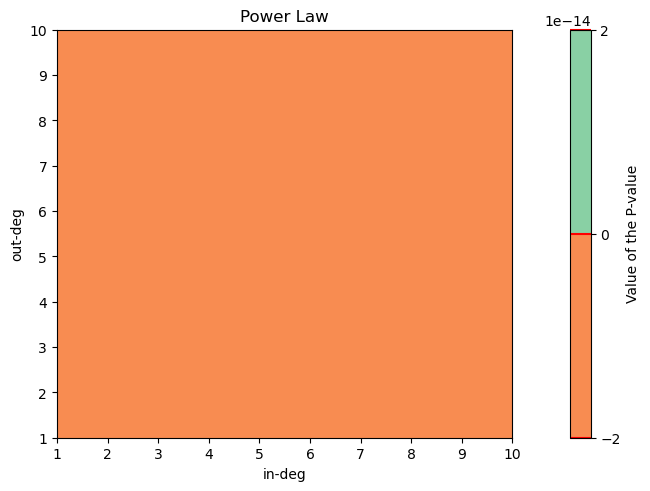

<Figure size 800x800 with 0 Axes>

In [36]:
x = np.linspace(1, 10, 10)  # In-degree
y = np.linspace(1, 10, 10)  # Out-degree
print (x)
print (y)
# Create a mesh grid
X, Y = np.meshgrid(x, y)
Z = np.vectorize(runPowerLawOverMesh)(X,Y)
plot(x=x,y=y,z=Z[4],txt='P-value')

#### In-degree Dimension

In [92]:
collection = []
for in_degree in range(1,10,1):
    lst = nodeInDegreeComplementary(H, min_node_length=0, in_threshold=in_degree, ttl=100)
    alpha, sigma, l, p = fitPowerLaw(lst)
    collection.append((in_degree, alpha, sigma, l, p))

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


In [93]:
deg = [int(x[0]) for x in collection]
alpha = [x[1] for x in collection]
likelihood =  [x[3] for x in collection]
p = [x[4] for x in collection]

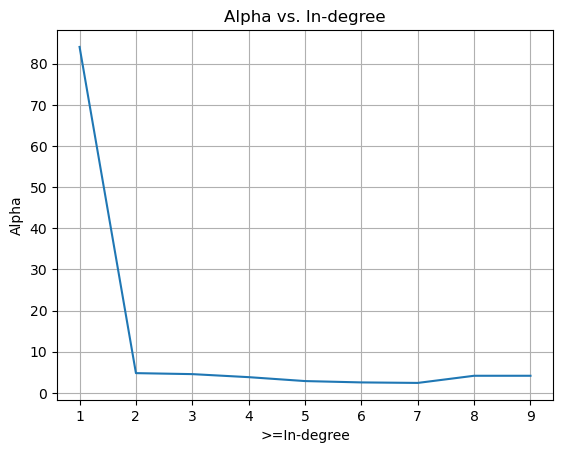

In [94]:
from scipy.interpolate import make_interp_spline, BSpline

# Create a new set of points for smoother plotting
xnew = np.linspace(min(deg), max(deg), 300)

# Fit a cubic spline to the data
spl = make_interp_spline(deg, alpha, k=3)
power_smooth = spl(xnew)

# Plot the smooth line
plt.plot(deg, alpha)
plt.xlabel(">=In-degree")
plt.ylabel("Alpha")
plt.title("Alpha vs. In-degree")
plt.grid(True)
plt.show()

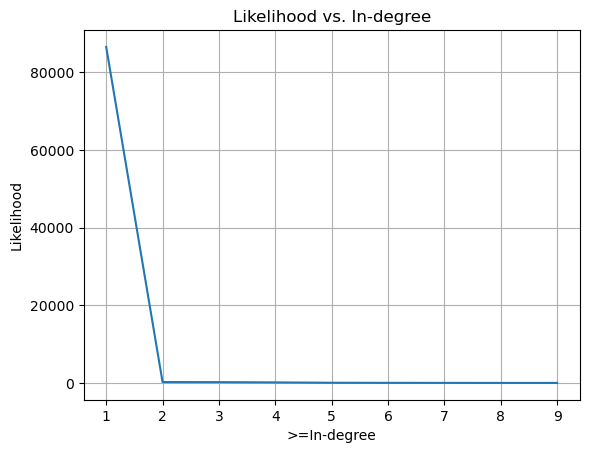

In [95]:
xnew = np.linspace(min(deg), max(deg), 300)

# Fit a cubic spline to the data
spl = make_interp_spline(deg, likelihood, k=3)
power_smooth = spl(xnew)

# Plot the smooth line
plt.plot(deg, likelihood)
plt.xlabel(">=In-degree")
plt.ylabel("Likelihood")
plt.title("Likelihood vs. In-degree")
plt.grid(True)
plt.show()

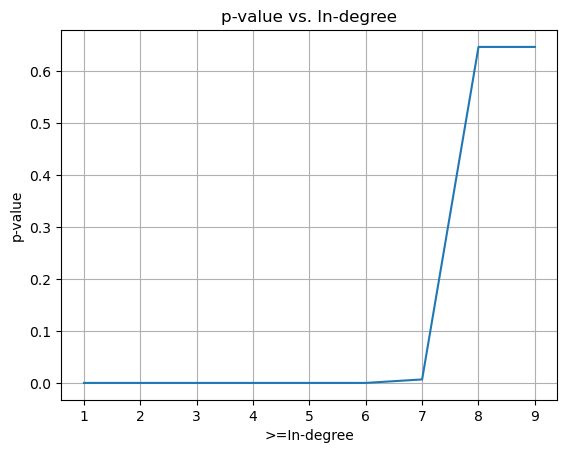

In [96]:
xnew = np.linspace(min(deg), max(deg), 300)

# Fit a cubic spline to the data
spl = make_interp_spline(deg, p, k=3)
power_smooth = spl(xnew)

# Plot the smooth line
plt.plot(deg, p)
plt.xlabel(">=In-degree")
plt.ylabel("p-value")
plt.title("p-value vs. In-degree")
plt.grid(True)
plt.show()

#### Out-degree Dimension

In [97]:
collection = []
for out_degree in range(1,6,1):
    lst = nodeOutDegreeComplementary(H, min_node_length=0, out_threshold=out_degree, ttl=100)
    alpha, sigma, l, p = fitPowerLaw(lst)
    collection.append((out_degree, alpha, sigma, l, p))

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


In [98]:
deg = [int(x[0]) for x in collection]
alpha = [x[1] for x in collection]
likelihood =  [x[3] for x in collection]
p = [x[4] for x in collection]

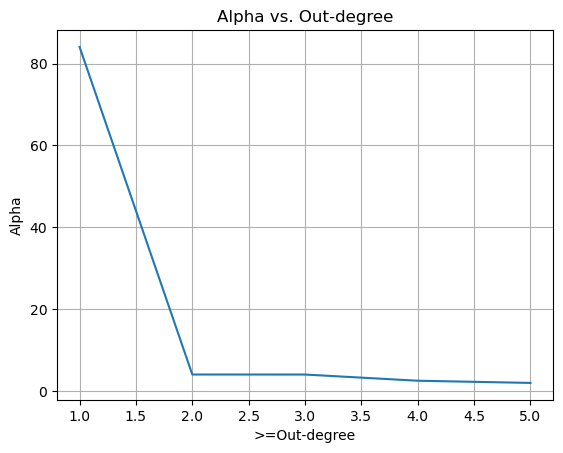

In [99]:
from scipy.interpolate import make_interp_spline, BSpline

# Create a new set of points for smoother plotting
xnew = np.linspace(min(deg), max(deg), 300)

# Fit a cubic spline to the data
spl = make_interp_spline(deg, alpha, k=3)
power_smooth = spl(xnew)

# Plot the smooth line
plt.plot(deg, alpha)
plt.xlabel(">=Out-degree")
plt.ylabel("Alpha")
plt.title("Alpha vs. Out-degree")
plt.grid(True)
plt.show()

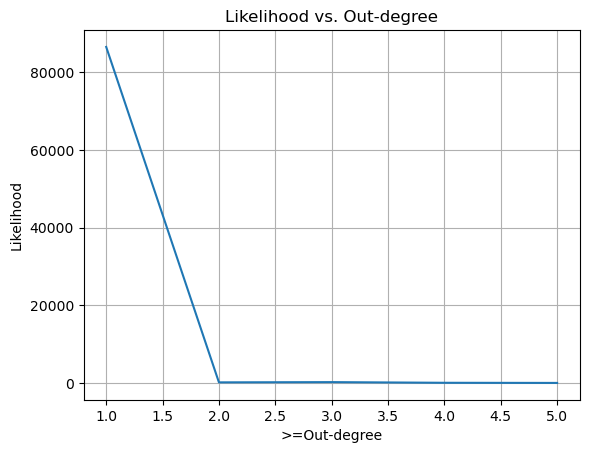

In [100]:
xnew = np.linspace(min(deg), max(deg), 300)

# Fit a cubic spline to the data
spl = make_interp_spline(deg, likelihood, k=3)
power_smooth = spl(xnew)

# Plot the smooth line
plt.plot(deg, likelihood)
plt.xlabel(">=Out-degree")
plt.ylabel("Likelihood")
plt.title("Likelihood vs. Out-degree")
plt.grid(True)
plt.show()

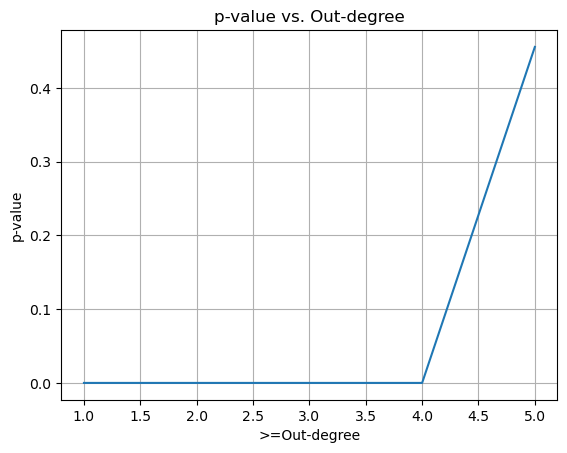

In [91]:
xnew = np.linspace(min(deg), max(deg), 300)

# Fit a cubic spline to the data
spl = make_interp_spline(deg, p, k=3)
power_smooth = spl(xnew)

# Plot the smooth line
plt.plot(deg, p)
plt.xlabel(">=Out-degree")
plt.ylabel("p-value")
plt.title("p-value vs. Out-degree")
plt.grid(True)
plt.show()

#### EDA

In [8]:
%%time
node_lst = list(H.nodes)
motif = []
for node in node_lst:
    for key, value in H.nodes[node].items():
        if value=='ngram':
            motif.append(node)
node_deg ={}
for m in motif:
    node_deg[m] = (H.in_degree[m], H.out_degree[m])

CPU times: user 212 ms, sys: 4.73 ms, total: 217 ms
Wall time: 217 ms


In [9]:
degrees = list(node_deg.values())

In [10]:
print(list(set(degrees)))

[(12, 1), (3, 4), (4, 3), (3, 1), (3, 7), (4, 6), (21, 22), (5, 1), (9, 2), (22, 23), (8, 3), (2, 2), (2, 5), (1, 3), (11, 11), (30, 30), (6, 2), (7, 1), (4, 2), (4, 5), (3, 3), (5, 6), (38, 40), (5, 3), (9, 1), (23, 24), (22, 28), (8, 8), (2, 4), (1, 2), (10, 11), (2, 1), (1, 5), (6, 1), (37, 38), (6, 7), (32, 32), (18, 18), (50, 50), (3, 2), (4, 1), (3, 5), (5, 2), (4, 4), (5, 5), (14, 14), (8, 4), (9, 3), (8, 1), (30, 1), (1, 1), (1, 4), (2, 3), (2, 9), (10, 10), (1, 7), (7, 2), (7, 8), (13, 15), (6, 3), (25, 26), (15, 15)]


In [21]:
deg_count = {}
for degree in degrees:
    if degree not in deg_count.keys():
        deg_count[degree] = 1
    else:
        deg_count[degree]+= 1

In [22]:
len(deg_count.keys())

62

In [31]:
lst = list(deg_count.keys())

In [33]:
in_deg = 0
out_deg = 0
for pair in lst:
    if pair[0]>in_deg:
        in_deg = pair[0]
    if pair[1]>out_deg:
        out_deg = pair[1]

In [34]:
in_deg, out_deg

(50, 50)

In [44]:
# Define x and y coordinates
x = np.linspace(1, 50, 50)  # In-degree
y = np.linspace(1, 50, 50)  # Out-degree
X, Y = np.meshgrid(x, y)

node_deg ={}
for m in motif:
    node_deg[m] = (H.in_degree[m], H.out_degree[m])
    
degrees = list(node_deg.values())

deg_count = {}
for degree in degrees:
    if degree not in deg_count.keys():
        deg_count[degree] = 1
    else:
        deg_count[degree]+= 1

def degCount(x,y):
    X = int(x)
    Y = int(y)
    if (X,Y) in deg_count.keys():
        return deg_count[(int(x),int(y))]
    else:
        return 0

Z = np.vectorize(degCount)(X,Y)

In [46]:
X

array([[ 1.,  2.,  3., ..., 48., 49., 50.],
       [ 1.,  2.,  3., ..., 48., 49., 50.],
       [ 1.,  2.,  3., ..., 48., 49., 50.],
       ...,
       [ 1.,  2.,  3., ..., 48., 49., 50.],
       [ 1.,  2.,  3., ..., 48., 49., 50.],
       [ 1.,  2.,  3., ..., 48., 49., 50.]])

In [47]:
Y

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 2.,  2.,  2., ...,  2.,  2.,  2.],
       [ 3.,  3.,  3., ...,  3.,  3.,  3.],
       ...,
       [48., 48., 48., ..., 48., 48., 48.],
       [49., 49., 49., ..., 49., 49., 49.],
       [50., 50., 50., ..., 50., 50., 50.]])

In [56]:
Z

array([[205769,   1389,    267, ...,      0,      0,      0],
       [  2255,    364,     60, ...,      0,      0,      0],
       [   172,     25,     35, ...,      0,      0,      0],
       ...,
       [     0,      0,      0, ...,      0,      0,      0],
       [     0,      0,      0, ...,      0,      0,      0],
       [     0,      0,      0, ...,      0,      0,      1]])

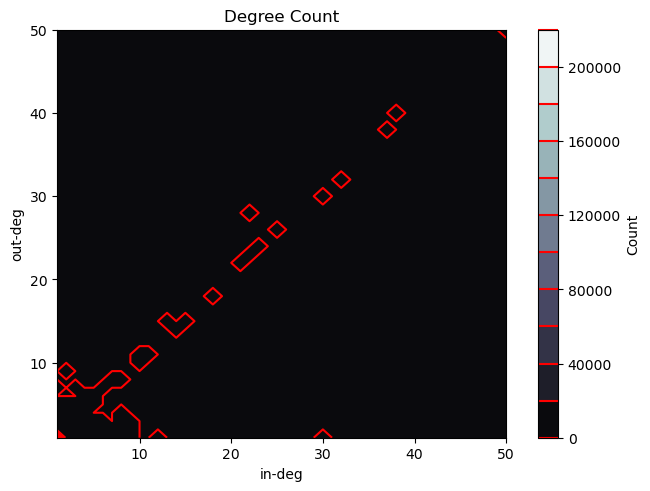

<Figure size 800x800 with 0 Axes>

In [59]:
fig1, ax2 = plt.subplots(layout='constrained')
plt.figure(figsize=(8,8))
# Create a mesh grid
X, Y = np.meshgrid(x, y)
# Plot the surface
z_grid = Z
CS = ax2.contourf(X, Y, z_grid, 10, cmap=plt.cm.bone)
CS2 = ax2.contour(CS,  colors='r')  # levels=CS.levels[::2],
ax2.set_title('Degree Count')
ax2.set_xlabel('in-deg')
ax2.set_ylabel('out-deg')
# Make a colorbar for the ContourSet returned by the contourf call.
cbar = fig1.colorbar(CS)
cbar.ax.set_ylabel('Count')
# Add the contour line levels to the colorbar
cbar.add_lines(CS2)

### Total degree equal or less than 10

#### When <b><i>min_node_length</i></b>=0

In [8]:
collection = []
for in_degree in range(1,10,1):
    lst = nodeInDegreeComplementary(H, min_node_length=0, in_threshold=in_degree, ttl=11)
    alpha, sigma, l, p = fitPowerLaw(lst)
    collection.append((in_degree, alpha, sigma, l, p))

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


In [9]:
deg = [int(x[0]) for x in collection]
alpha = [x[1] for x in collection]
likelihood =  [x[3] for x in collection]
p = [x[4] for x in collection]

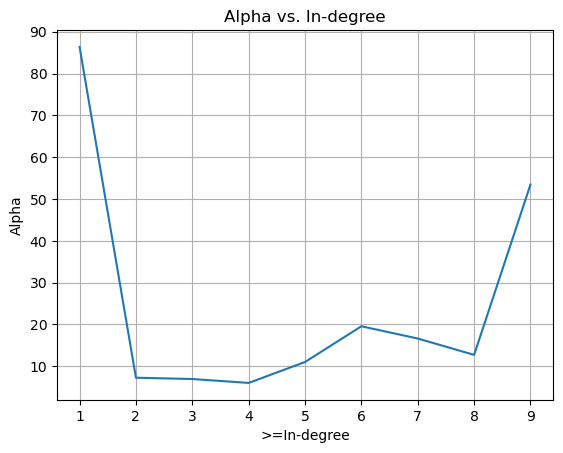

In [10]:
# Plot Alpha against the in-degree
plt.plot(deg, alpha)
plt.xlabel(">=In-degree")
plt.ylabel("Alpha")
plt.title("Alpha vs. In-degree")
plt.grid(True)
plt.show()

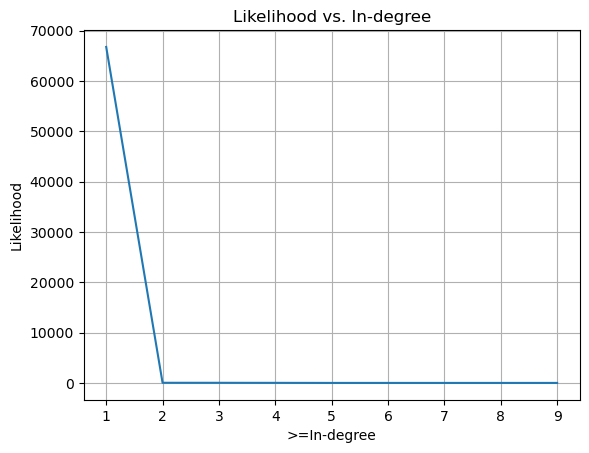

In [11]:
plt.plot(deg, likelihood)
plt.xlabel(">=In-degree")
plt.ylabel("Likelihood")
plt.title("Likelihood vs. In-degree")
plt.grid(True)
plt.show()

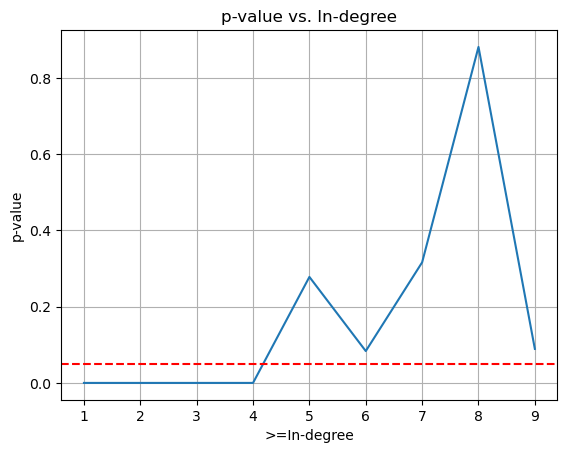

In [12]:
plt.plot(deg, p)
plt.axhline(y=0.05, color='r', linestyle='--') # Let's set the significant level at 0.05
plt.xlabel(">=In-degree")
plt.ylabel("p-value")
plt.title("p-value vs. In-degree")
plt.grid(True)
plt.show()

In [8]:
x = np.linspace(1, 9, 9) # In-degree
y = np.linspace(1, 9, 9) # Out-degree
print (x)
print (y)
# Create a mesh grid
X, Y = np.meshgrid(x, y)
Z = np.vectorize(runPowerLawOverMesh)(X,Y)
plot(x=x,y=y,z=Z[2],txt='Alpha')

[1. 2. 3. 4. 5. 6. 7. 8. 9.]
[1. 2. 3. 4. 5. 6. 7. 8. 9.]


NameError: name 'H' is not defined

[1. 2. 3. 4.]
[1. 2. 3. 4.]
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


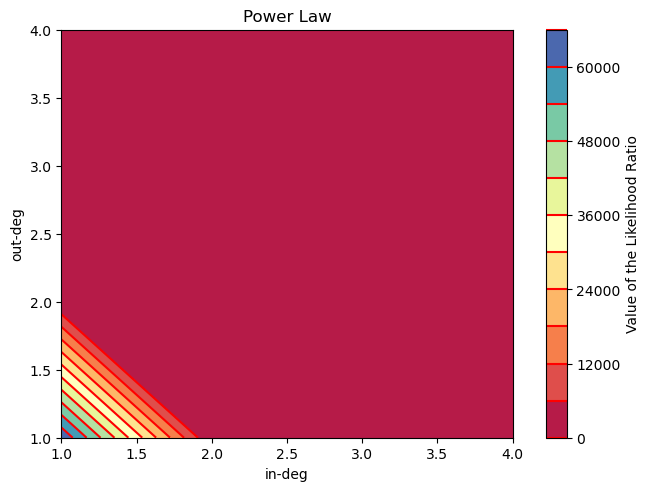

<Figure size 800x800 with 0 Axes>

In [30]:
x = np.linspace(1, 4, 4) # In-degree
y = np.linspace(1, 4, 4) # Out-degree
print (x)
print (y)
# Create a mesh grid
X, Y = np.meshgrid(x, y)
Z = np.vectorize(runPowerLawOverMesh)(X,Y)
plot(x=x,y=y,z=Z[3],txt='Likelihood Ratio')

[1. 2. 3. 4.]
[1. 2. 3. 4.]
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


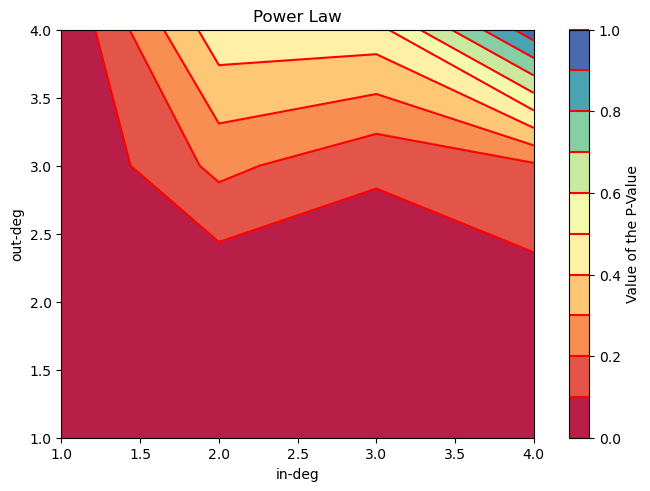

<Figure size 800x800 with 0 Axes>

In [29]:
x = np.linspace(1, 4, 4) # In-degree
y = np.linspace(1, 4, 4) # Out-degree
print (x)
print (y)
# Create a mesh grid
X, Y = np.meshgrid(x, y)
Z = np.vectorize(runPowerLawOverMesh)(X,Y)
plot(x=x,y=y,z=Z[4],txt='P-Value')

#### Total Degree > 10

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def runPowerLawOverMesh(X,Y):
    lst = nodeInandOutDegreeRefined(H, min_node_length=0, in_threshold=10, out_threshold=10, 
                                    in_deg=True, out_deg=True, suppress_print=True)
    alpha, sigma, l, p = fitPowerLaw(lst)
    return (X, Y, float(alpha), float(l), float(p))

# Define x and y coordinates
x = np.linspace(11, 30, 20)  # In-degree
y = np.linspace(11, 30, 20)  # Out-degree
#print (x)
#print (y)
# Create a mesh grid
X, Y = np.meshgrid(x, y)
Z = np.vectorize(runPowerLawOverMesh)(X,Y)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best min

In [27]:
Z[4]

array([[0.64599214, 0.64599214, 0.64599214, 0.64599214, 0.64599214,
        0.64599214, 0.64599214, 0.64599214, 0.64599214, 0.64599214,
        0.64599214, 0.64599214, 0.64599214, 0.64599214, 0.64599214,
        0.64599214, 0.64599214, 0.64599214, 0.64599214, 0.64599214],
       [0.64599214, 0.64599214, 0.64599214, 0.64599214, 0.64599214,
        0.64599214, 0.64599214, 0.64599214, 0.64599214, 0.64599214,
        0.64599214, 0.64599214, 0.64599214, 0.64599214, 0.64599214,
        0.64599214, 0.64599214, 0.64599214, 0.64599214, 0.64599214],
       [0.64599214, 0.64599214, 0.64599214, 0.64599214, 0.64599214,
        0.64599214, 0.64599214, 0.64599214, 0.64599214, 0.64599214,
        0.64599214, 0.64599214, 0.64599214, 0.64599214, 0.64599214,
        0.64599214, 0.64599214, 0.64599214, 0.64599214, 0.64599214],
       [0.64599214, 0.64599214, 0.64599214, 0.64599214, 0.64599214,
        0.64599214, 0.64599214, 0.64599214, 0.64599214, 0.64599214,
        0.64599214, 0.64599214, 0.64599214, 0

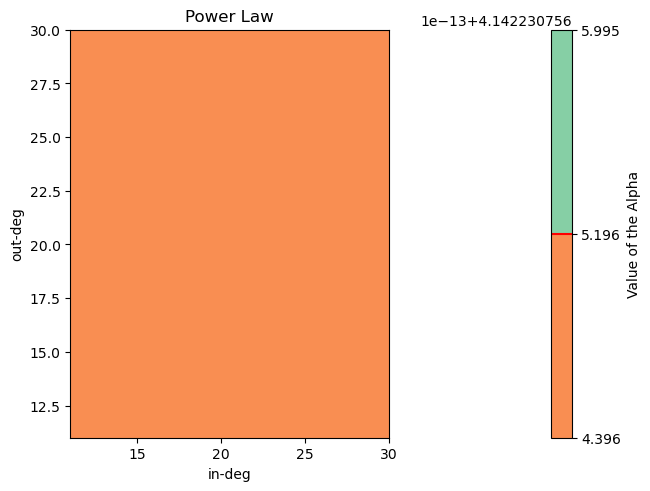

<Figure size 800x800 with 0 Axes>

In [25]:
plot(x=Z[0],y=Z[1],z=Z[2],txt='Alpha')

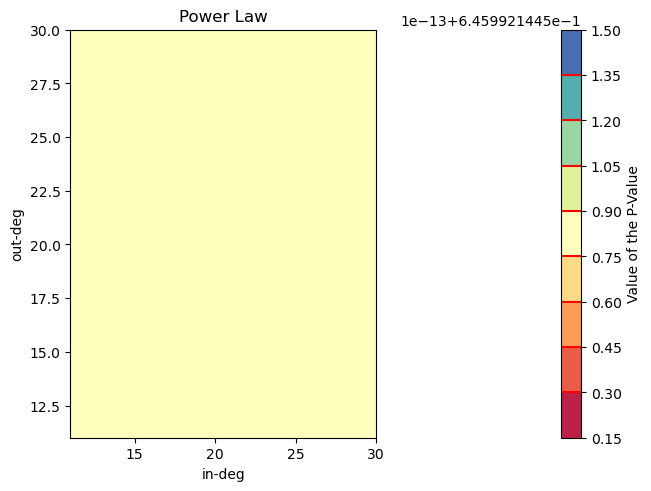

<Figure size 800x800 with 0 Axes>

In [26]:
plot(x=Z[0],y=Z[1],z=Z[4],txt='P-Value')